In [1]:
import wrangle_zillow
import explore

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
import scipy.stats as stats

from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error

# ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = wrangle_zillow.get_zillow()


In [3]:
df = wrangle_zillow.clean_zillow(df)

In [4]:
df = explore.add_new_columns(df)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 42136 entries, 0 to 52318
Data columns (total 33 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   bathrooms                       42136 non-null  float16       
 1   bedrooms                        42136 non-null  uint8         
 2   square_footage                  42136 non-null  uint16        
 3   county                          42136 non-null  object        
 4   latitude                        42136 non-null  float64       
 5   longitude                       42136 non-null  float64       
 6   lot_size                        42136 non-null  float64       
 7   yearbuilt                       42136 non-null  uint16        
 8   structure_tax_value             42136 non-null  float64       
 9   tax_value                       42136 non-null  float64       
 10  land_tax_value                  42136 non-null  float64       
 11  ta

In [6]:
columns_to_scale = ['bathrooms','bedrooms','square_footage','latitude','longitude','lot_size','yearbuilt',
 'structure_tax_value','tax_value','land_tax_value','taxamount','scaledyear_to_scaledtax',
 'home_price_per_sq_ft','land_price_per_lot_sq_ft', 'summer_scaledyear_to_scaledtax', 'sunday_fall']

In [7]:
train, validate, test, train_scaled, validate_scaled, test_scaled = wrangle_zillow.prepare_all_data(df, columns_to_scale)

# Modeling 

Setting X and y for train, validate and test.

In [8]:
X_train = train_scaled[['bathrooms', 'bedrooms', 'square_footage','tax_value', 
                        'season_spring','season_fall','summer_scaledyear_to_scaledtax','sunday_fall','lot_size',
                        'yearbuilt']]
y_train = pd.DataFrame(train_scaled.logerror)


X_validate = validate_scaled[['bathrooms', 'bedrooms', 'square_footage','tax_value', 
                        'season_spring','season_fall','summer_scaledyear_to_scaledtax','sunday_fall','lot_size',
                        'yearbuilt']]
y_validate = pd.DataFrame(validate_scaled.logerror)

X_test = test_scaled[['bathrooms', 'bedrooms', 'square_footage','tax_value', 
                        'season_spring','season_fall','summer_scaledyear_to_scaledtax','sunday_fall','lot_size',
                        'yearbuilt']]
y_test = pd.DataFrame(test_scaled.logerror)

Setting baselines based on the mean and median.

In [9]:
# Predicting the mean for taxvaluedollarcnt

logerror_mean = y_train.logerror.mean()
y_train['logerror_pred_mean'] = logerror_mean
y_validate['logerror_pred_mean'] = logerror_mean
y_test['logerror_pred_mean'] = logerror_mean

In [10]:
# Predicting the median for taxvaluedollarcnt

logerror_median = y_train.logerror.median()
y_train['logerror_pred_median'] = logerror_median
y_validate['logerror_pred_median'] = logerror_median
y_test['logerror_pred_median'] = logerror_median

In [11]:
y_train.head()

,logerror,logerror_pred_mean,logerror_pred_median
35454,-0.004393,0.00501,0.004832
3249,-0.053424,0.00501,0.004832
40108,0.029549,0.00501,0.004832
8843,-0.023743,0.00501,0.004832
15343,0.032236,0.00501,0.004832


In [18]:
# Getting the RMSE taxvalue_pred_mean

rmse_train = mean_squared_error(y_train.logerror, y_train.logerror_pred_mean)**(1/2)
rmse_validate = mean_squared_error(y_validate.logerror, y_validate.logerror_pred_mean)**(1/2)

print("RMSE using Mean\nTrain/In-Sample: ", rmse_train, 
      "\nValidate/Out-of-Sample: ", rmse_validate)

# Getting the RMSE taxvalue_pred_median
rmse_train = mean_squared_error(y_train.logerror, y_train.logerror_pred_median)**(1/2)
rmse_validate = mean_squared_error(y_validate.logerror, y_validate.logerror_pred_median)**(1/2)

print("\nRMSE using Median\nTrain/In-Sample: ", rmse_train, 
      "\nValidate/Out-of-Sample: ", rmse_validate)

RMSE using Mean
Train/In-Sample:  0.055492469733837424 
Validate/Out-of-Sample:  0.05475500966675738

RMSE using Median
Train/In-Sample:  0.05549275681923627 
Validate/Out-of-Sample:  0.05475430782334583


# Linear Regression (OLS)
Creating and validating a Linear Regression model.

In [14]:
# create the model
lm = LinearRegression()

#fit the model
lm.fit(X_train, y_train.logerror)

# predict train
y_train['logerror_pred_lm'] = lm.predict(X_train)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.logerror, y_train.logerror_pred_lm)**(1/2)

# predict validate
y_validate['logerror_pred_lm'] = lm.predict(X_validate)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.logerror, y_validate.logerror_pred_lm)**(1/2)

print("RMSE for OLS using LinearRegression\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for OLS using LinearRegression
Training/In-Sample:  0.05527017103228721 
Validation/Out-of-Sample:  0.054481254464051776


# LassoLars
Creating and validating a LassoLars model.

In [16]:
# create the model
lars = LassoLars(alpha=1.0)

# fit the model
lars.fit(X_train, y_train.logerror)

# predict train
y_train['logerror_pred_lars'] = lars.predict(X_train)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.logerror, y_train.logerror_pred_lars)**(1/2)

# predict validate
y_validate['logerror_pred_lars'] = lars.predict(X_validate)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.logerror, y_validate.logerror_pred_lars)**(1/2)

print("RMSE for OLS using LassoLars\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for OLS using LassoLars
Training/In-Sample:  0.05549246973383742 
Validation/Out-of-Sample:  0.05475500966675738


# Polynomial Regression
Creating and validatiing a polynomial regressor.

In [20]:
# making the polynomial features to get a new set of features
pf = PolynomialFeatures(degree=2)

# fit and transform X_train_scaled
X_train_degree2 = pf.fit_transform(X_train)

# transform X_validate_scaled & X_test_scaled
X_validate_degree2 = pf.transform(X_validate)
X_test_degree2 = pf.transform(X_test)

In [22]:
# create the model
lm2 = LinearRegression(normalize=True)

#fit the model
lm2.fit(X_train_degree2, y_train.logerror)

# predict train
y_train['logerror_pred_lm2'] = lm2.predict(X_train_degree2)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.logerror, y_train.logerror_pred_lm2)**(1/2)

# predict validate
y_validate['logerror_pred_lm2'] = lm2.predict(X_validate_degree2)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.logerror, y_validate.logerror_pred_lm2)**(1/2)

print("RMSE for OLS using Polynomial Regression\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for OLS using Polynomial Regression
Training/In-Sample:  0.05513813833736084 
Validation/Out-of-Sample:  0.05448943367865541


# Other models

First I will bring in other models to see if any offer a better regression.

In [23]:
# importing other models to use
from sklearn.linear_model import Lars, Lasso, LassoLarsCV, LassoLarsIC, Ridge, SGDRegressor, ARDRegression, BayesianRidge, HuberRegressor, PassiveAggressiveRegressor


In [33]:
for model in [Lars(), Lasso(), LassoLarsCV(), LassoLarsIC(), Ridge(), SGDRegressor(), ARDRegression(), BayesianRidge(), HuberRegressor(), PassiveAggressiveRegressor()]:
    # create the model
    test_model = model

    # fit the model
    test_model.fit(X_train, y_train.logerror)

    # predict train
    y_train['logerror_pred_test'] = test_model.predict(X_train)

    # evaluate: rmse
    rmse_train = mean_squared_error(y_train.logerror, y_train.logerror_pred_test)**(1/2)

    # predict validate
    y_validate['logerror_pred_test'] = test_model.predict(X_validate)

    # evaluate: rmse
    rmse_validate = mean_squared_error(y_validate.logerror, y_validate.logerror_pred_test)**(1/2)

    print(f"\nRMSE for {model}\nTraining/In-Sample: ", rmse_train, 
          "\nValidation/Out-of-Sample: ", rmse_validate)


RMSE for Lars()
Training/In-Sample:  0.05527017103228721 
Validation/Out-of-Sample:  0.054481254464051776

RMSE for Lasso()
Training/In-Sample:  0.05549246973383742 
Validation/Out-of-Sample:  0.05475500966675738

RMSE for LassoLarsCV()
Training/In-Sample:  0.055272537651840786 
Validation/Out-of-Sample:  0.05447766444630856

RMSE for LassoLarsIC()
Training/In-Sample:  0.055271780815133766 
Validation/Out-of-Sample:  0.05447751057441729

RMSE for Ridge()
Training/In-Sample:  0.055270174714798365 
Validation/Out-of-Sample:  0.0544811150702291

RMSE for SGDRegressor()
Training/In-Sample:  0.05529642882076499 
Validation/Out-of-Sample:  0.054496334394458834

RMSE for ARDRegression()
Training/In-Sample:  0.0553727916137998 
Validation/Out-of-Sample:  0.054550861845366894

RMSE for BayesianRidge()
Training/In-Sample:  0.05527236126157863 
Validation/Out-of-Sample:  0.054480339659395124

RMSE for HuberRegressor()
Training/In-Sample:  0.05528539096787592 
Validation/Out-of-Sample:  0.0545135

Finally I wanna try to use a decision tree regressor

In [32]:
from sklearn.tree import DecisionTreeRegressor

regr_1 = DecisionTreeRegressor(max_depth=2)
regr_2 = DecisionTreeRegressor(max_depth=3)
regr_3 = DecisionTreeRegressor(max_depth=4)
regr_4 = DecisionTreeRegressor(max_depth=5)
regr_5 = DecisionTreeRegressor(max_depth=8)
regr_6 = DecisionTreeRegressor(max_depth=10)

for model in [regr_1, regr_2,regr_3,regr_4,regr_5,regr_6]:
    # create the model
    test_model = model

    # fit the model
    test_model.fit(X_train, y_train.logerror)

    # predict train
    y_train['logerror_pred_test'] = test_model.predict(X_train)

    # evaluate: rmse
    rmse_train = mean_squared_error(y_train.logerror, y_train.logerror_pred_test)**(1/2)

    # predict validate
    y_validate['logerror_pred_test'] = test_model.predict(X_validate)

    # evaluate: rmse
    rmse_validate = mean_squared_error(y_validate.logerror, y_validate.logerror_pred_test)**(1/2)

    print(f"\nRMSE for {model}\nTraining/In-Sample: ", rmse_train, 
          "\nValidation/Out-of-Sample: ", rmse_validate)


RMSE for DecisionTreeRegressor(max_depth=2)
Training/In-Sample:  0.05532925943555161 
Validation/Out-of-Sample:  0.054558322379920414

RMSE for DecisionTreeRegressor(max_depth=3)
Training/In-Sample:  0.05526069291682844 
Validation/Out-of-Sample:  0.054555752256070546

RMSE for DecisionTreeRegressor(max_depth=4)
Training/In-Sample:  0.05513489924055418 
Validation/Out-of-Sample:  0.05461360302685435

RMSE for DecisionTreeRegressor(max_depth=5)
Training/In-Sample:  0.05493128142315069 
Validation/Out-of-Sample:  0.05485064732252786

RMSE for DecisionTreeRegressor(max_depth=8)
Training/In-Sample:  0.05395444580941379 
Validation/Out-of-Sample:  0.055645758239032485

RMSE for DecisionTreeRegressor(max_depth=10)
Training/In-Sample:  0.052940107957339555 
Validation/Out-of-Sample:  0.05684131451616609


The best performing DecisionTreeRegressor is max_depth 3

In [34]:
# initial_model_results = pd.read_clipboard()

# initial_model_results

,model,train_RMSE,validate_RMSE
0,train_mean,0.055492,0.054755
1,train_median,0.055493,0.054754
2,linear_regression_ols,0.055270,0.054481
3,lasso_lars,0.055492,0.054755
4,polynomial_regression,0.055138,0.054489
5,least_angle_lars,0.055270,0.054481
6,coordinate_descent_lasso,0.055492,0.054755
7,least_angle_LassoLarsCV,0.055273,0.054478
8,least_angle_LassoLarsIC,0.055272,0.054478
9,ridge_regressor,0.055270,0.054481


In [35]:
# initial_model_results.to_csv('model_results.csv', index=False)
model_results = pd.read_csv('model_results.csv')

In [36]:
model_results

,model,train_RMSE,validate_RMSE
0,train_mean,0.055492,0.054755
1,train_median,0.055493,0.054754
2,linear_regression_ols,0.055270,0.054481
3,lasso_lars,0.055492,0.054755
4,polynomial_regression,0.055138,0.054489
5,least_angle_lars,0.055270,0.054481
6,coordinate_descent_lasso,0.055492,0.054755
7,least_angle_LassoLarsCV,0.055273,0.054478
8,least_angle_LassoLarsIC,0.055272,0.054478
9,ridge_regressor,0.055270,0.054481


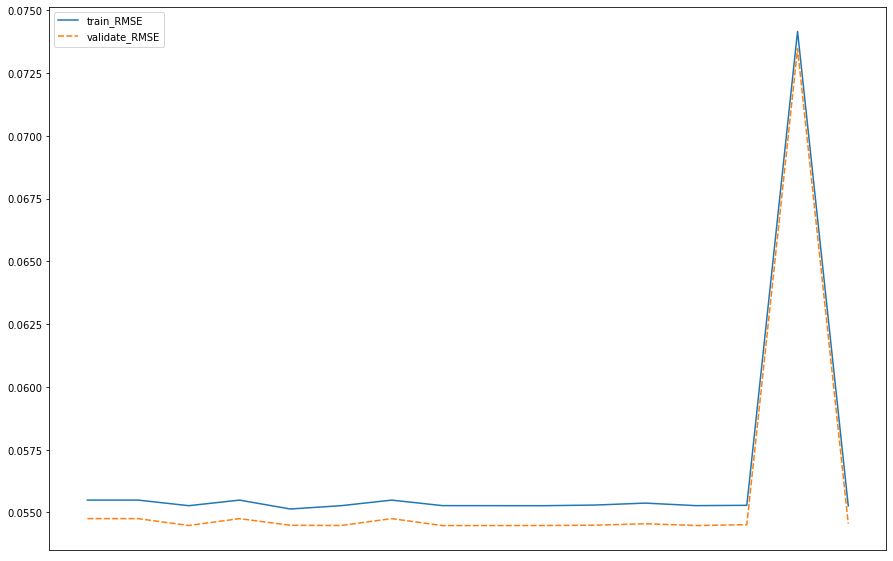

In [38]:
plt.figure(figsize=(15,10))
mod = sns.lineplot(data=model_results)
mod.set(xticklabels=[])
mod.set(xticks=[])
plt.show()

Passive Aggressive is throwing off the plot of the results so I'm going to throw it out in order to better visualize the data.

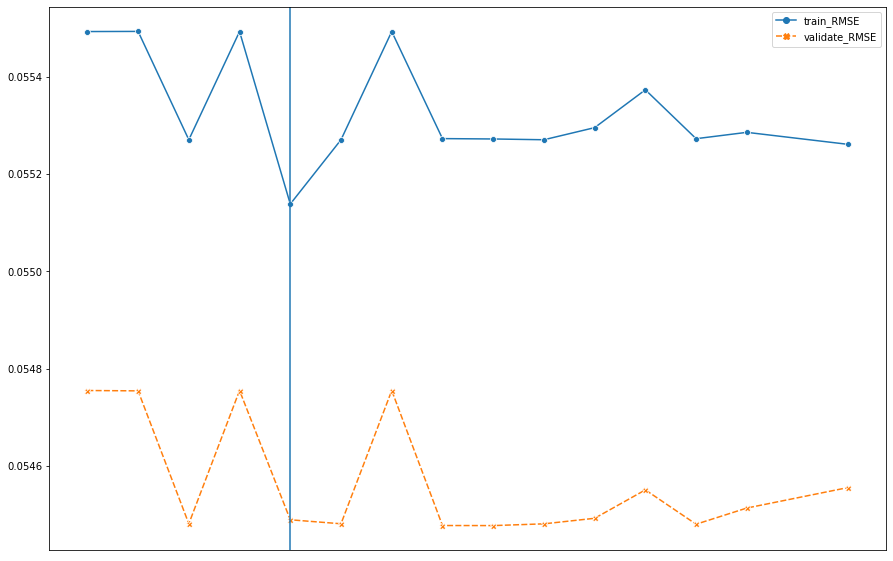

In [58]:
plt.figure(figsize=(15,10))
mod = sns.lineplot(data=model_results[model_results.model != 'passive_aggressive_regressor'], markers=True)
mod.axvline(4)
mod.set(xticklabels=[])
mod.set(xticks=[])
plt.show()

In [55]:
model_results.sort_values('validate_RMSE')

,model,train_RMSE,validate_RMSE
8,least_angle_LassoLarsIC,0.055272,0.054478
7,least_angle_LassoLarsCV,0.055273,0.054478
12,bayesian_ridge,0.055272,0.054480
9,ridge_regressor,0.055270,0.054481
2,linear_regression_ols,0.055270,0.054481
5,least_angle_lars,0.055270,0.054481
4,polynomial_regression,0.055138,0.054489
10,sgd_regressor,0.055295,0.054493
13,huber_regressor,0.055285,0.054514
11,ard_regressor,0.055373,0.054551


In [56]:
model_results.sort_values('train_RMSE')

,model,train_RMSE,validate_RMSE
4,polynomial_regression,0.055138,0.054489
15,decision_tree_regressor,0.055261,0.054556
2,linear_regression_ols,0.055270,0.054481
5,least_angle_lars,0.055270,0.054481
9,ridge_regressor,0.055270,0.054481
8,least_angle_LassoLarsIC,0.055272,0.054478
12,bayesian_ridge,0.055272,0.054480
7,least_angle_LassoLarsCV,0.055273,0.054478
13,huber_regressor,0.055285,0.054514
10,sgd_regressor,0.055295,0.054493
